In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from pylab import rcParams
from sklearn.metrics import confusion_matrix
import pyltr

import data_preprocessing
%matplotlib inline
params = {'axes.labelsize': 14,'axes.titlesize':14, 'text.fontsize': 14, 'legend.fontsize': 14,
          'xtick.labelsize': 13, 'ytick.labelsize': 14}
rcParams['figure.figsize'] = 6.5, 4

matplotlib.rcParams.update(params)

from collections import OrderedDict

import utils
from operator import itemgetter

import nDCG

/home/marleen/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [79]:
import imp
utils = imp.reload(utils)
nDCG = imp.reload(nDCG)

In [2]:
balance_flag = True
downsampling_rate = 3
learning_rate = 0.05


In [3]:
#Training file
df=pd.read_pickle('cleaned_dataset')

# add column with relevance scores
df['relevance'] = df['booking_bool'] + df['click_bool']

# change relevance column with relevance score (1 if clicked, 5 if booked)
df['relevance'] = df['relevance'].map({0:0, 1:1, 2:5})

# all_cols = df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position'])
# for feature in all_cols:
#     df[feature] = df[feature].replace([np.inf, -np.inf], np.nan)
#     df[feature][df[feature].isnull()] = df[feature].median()
    


In [4]:

# create list of ids in random order
id_list = df.srch_id.unique()
np.random.shuffle(id_list)

# for reproducibility 
np.random.seed(1337)

# training - test fraction is 70/30
id_train = int(len(id_list) * 0.7)
id_val = int(len(id_list) * 0.9)

training_id = id_list[:id_train]
validation_id = id_list[id_train:id_val]

test_id = id_list[id_val:]

# divide dataset in test and training set
train = df.loc[df.srch_id.isin(training_id)]
val = df.loc[df.srch_id.isin(validation_id)]
test = df.loc[df.srch_id.isin(test_id)]

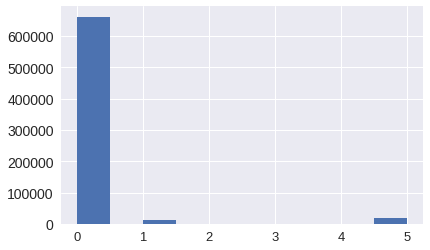

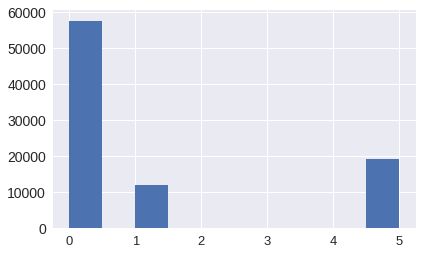

In [5]:
from sklearn.utils import resample

train['relevance'].hist()

plt.show()
def balance_dataset(train, downsampling_rate):
    
    # Separate majority and minority classes
    df_majority = train[train.relevance==0]
    df_minority = train[train.relevance==5]
    df_minority2 = train[train.relevance==1]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=df_minority.shape[0]*downsampling_rate,     # to match minority class
                                     random_state=123) # reproducible results


    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority, df_minority2])

    # Display new class counts
    df_downsampled.relevance.value_counts()

    df_downsampled['relevance'].hist()
    #df_downsampled['relevance'].value_counts()
    train = df_downsampled
    train = train.sort_values('srch_id')
    return train

if balance_flag:
    train = balance_dataset(train,downsampling_rate)



In [6]:
#Efi's code for data cleaning
df.shape

(1000000, 60)

In [7]:
##Unorthodox Implementation - vectors or fearures need to be reduced/rearranged

#Select the same features from each dataset
selected_features = ['comp6_rate_percent_diff_signed',
 'comp4_rate_percent_diff_signed',
 'comp8_rate_percent_diff_signed',
 'comp7_rate_percent_diff_signed',
 'star_diff_from_historic_mean',
 'visitor_hist_adr_usd',
 'srch_query_affinity_score',
 'srch_room_count',
 'visitor_hist_starrating',
 'price_diff_from_historic_mean',
 'srch_adults_count',
 'prop_brand_bool',
 'prop_country_id',
 'visitor_location_country_id',
 'prop_starrating',
 'prop_review_score',
 'srch_saturday_night_bool',
 'site_id',
 'srch_length_of_stay',
 'prop_starrating_monot',
 'random_bool',
 'promotion_flag',
 'prop_location_score_mean',
 'orig_destination_distance',
 'srch_children_count',
 'prop_location_score2',
 'prop_id',
 'star_rank']




In [8]:
selected_features = ['visitor_hist_adr_usd',
 'star_diff_from_historic_mean',
 'comp1_rate_percent_diff_log',
 'srch_query_affinity_score',
 'srch_room_count',
 'visitor_hist_starrating',
 'price_diff_from_historic_mean',
 'comp1_rate_percent_diff_signed',
 'comp7_rate_percent_diff_signed',
 'srch_adults_count',
 'prop_brand_bool',
 'prop_country_id',
 'visitor_location_country_id',
 'comp6_rate_percent_diff_signed',
 'prop_starrating',
 'prop_review_score',
 'srch_saturday_night_bool',
 'random_bool',
 'site_id',
 'srch_length_of_stay',
 'prop_starrating_monot',
 'srch_id',
 'orig_destination_distance',
 'promotion_flag',
 'price_rank',
 'star_rank',
 'srch_destination_id',
 'srch_children_count',
 'prop_location_score2_norm',
 'prop_location_score1_norm',
 'price_usd_norm_srch_id',
 'prop_location_score2',
 'prop_id',
 'prop_location_score_mean',
 'srch_booking_window',
 'value_for_money_norm_srch_id',
 'comp5_inv',
 'value_for_money',
 'comp_rate_percent_diff_mean',
 'prop_log_historical_price',
 'price_usd',
 'prop_location_score1',
 'comp2_inv',
 'comp2_rate_percent_diff_signed',
 'comp1_inv',
 'comp3_inv',
 'comp8_inv',
 'log_price_usd',
 'comp4_inv',
 'comp3_rate_percent_diff_signed',
 'comp7_inv',
 'price_usd_norm_prop_id',
 'comp4_rate_percent_diff_signed',
 'comp5_rate_percent_diff_signed',
 'comp6_inv']


TO_DROP=[
 'comp1_rate','comp2_rate','comp3_rate','comp4_rate','comp5_rate',
 'comp6_rate','comp7_rate','comp8_rate',
 'comp6_rate_percent_diff',
 'comp4_rate_percent_diff',
 'comp7_rate_percent_diff',
 'comp1_rate_percent_diff',
 'comp3_rate_percent_diff',
 'comp2_rate_percent_diff',
 'comp8_rate_percent_diff',
 'comp5_rate_percent_diff',
 'comp1_rate_percent_diff_signed_norm',
 'comp2_rate_percent_diff_signed_norm',
 'comp4_rate_percent_diff_signed_norm',
 'comp8_rate_percent_diff_signed_norm',
 'comp3_rate_percent_diff_signed_norm',
 'comp5_rate_percent_diff_signed_norm',
 'comp6_rate_percent_diff_signed_norm',
 'comp7_rate_percent_diff_signed_norm',
 'prop_location_score1',
 'prop_location_score2']

selected_features = list(set(selected_features))
TO_DROP = list(set(TO_DROP))

for feat in list(TO_DROP):
    if feat in selected_features:
        selected_features.remove(feat)

In [9]:
features_to_keep = ['booking_bool', 'srch_id', 'click_bool', 'prop_id', 'relevance']
selected_features = list(set(set(selected_features).difference(features_to_keep)))
all_possible_features = features_to_keep + selected_features

all_possible_features = list(set(all_possible_features))
df_to_train = train.ix[:,all_possible_features]
df_to_val = val.ix[:,all_possible_features]
df_to_test = test.ix[:,all_possible_features]



#Since we've created a new variable that combined those two, there's no need in keeping them
df_to_train.drop(['booking_bool', 'click_bool'], axis = 1)
df_to_val.drop(['booking_bool', 'click_bool'], axis = 1)
df_to_test.drop(['booking_bool', 'click_bool'], axis = 1)

#Rearrange the columns because lambdaMART wants the target variable and the IDs in the first and second column respectively
df_to_train = df_to_train[['relevance', 'srch_id', 'prop_id']+selected_features]
df_to_val =  df_to_val[['relevance', 'srch_id', 'prop_id']+selected_features]
df_to_test =  df_to_test[['relevance', 'srch_id', 'prop_id']+selected_features]


/home/marleen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/marleen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/home/marleen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


# Downsample majority class

In [10]:
feats = list(df_to_test[selected_features].columns)
feats

['price_diff_from_historic_mean',
 'comp6_rate_percent_diff_signed',
 'comp1_rate_percent_diff_signed',
 'comp7_rate_percent_diff_signed',
 'prop_brand_bool',
 'price_usd_norm_srch_id',
 'value_for_money_norm_srch_id',
 'orig_destination_distance',
 'comp3_inv',
 'srch_query_affinity_score',
 'prop_location_score_mean',
 'srch_adults_count',
 'comp6_inv',
 'srch_children_count',
 'prop_log_historical_price',
 'comp1_inv',
 'visitor_location_country_id',
 'srch_destination_id',
 'comp7_inv',
 'visitor_hist_adr_usd',
 'prop_starrating_monot',
 'prop_country_id',
 'price_usd_norm_prop_id',
 'comp2_rate_percent_diff_signed',
 'comp_rate_percent_diff_mean',
 'comp4_rate_percent_diff_signed',
 'price_usd',
 'comp3_rate_percent_diff_signed',
 'site_id',
 'prop_location_score1_norm',
 'prop_starrating',
 'srch_saturday_night_bool',
 'visitor_hist_starrating',
 'value_for_money',
 'srch_booking_window',
 'price_rank',
 'star_diff_from_historic_mean',
 'srch_length_of_stay',
 'comp5_rate_percent

In [11]:
all_na_cols=[]
for col in df_to_train[selected_features]:
    data = df_to_train[col]
    if data.isnull().all(): 
        print(col)
        all_na_cols.append(col)
        
    

comp6_rate_percent_diff_signed
comp1_rate_percent_diff_signed
comp7_rate_percent_diff_signed
price_usd_norm_srch_id
value_for_money_norm_srch_id
prop_location_score_mean
prop_starrating_monot
price_usd_norm_prop_id
comp2_rate_percent_diff_signed
comp_rate_percent_diff_mean
comp4_rate_percent_diff_signed
comp3_rate_percent_diff_signed
prop_location_score1_norm
comp5_rate_percent_diff_signed
log_price_usd
prop_location_score2_norm
comp1_rate_percent_diff_log


In [12]:
selected_features=set(selected_features)
selected_features = list(selected_features.difference(all_na_cols))

In [13]:
#From dataframes to arrays
trrelevance_arr = np.array(df_to_train['relevance'])
trfeature_arr = np.array(df_to_train[selected_features])
trid_arr = np.array(df_to_train.srch_id)

vrelevance_arr = np.array(df_to_val['relevance'])
vfeature_arr = np.array(df_to_val[selected_features])
vid_arr = np.array(df_to_val.srch_id)

terelevance_arr = np.array(df_to_test['relevance'])
tefeature_arr = np.array(df_to_test[selected_features])
teid_arr = np.array(df_to_test.srch_id)

In [71]:
#Choose nDCG as metric (k arbitrary number)
metric = pyltr.metrics.NDCG(k=31)

#Use validation set, stop_after arbitrary number
# Only needed if you want to perform validation (early stopping & trimming)
monitor = pyltr.models.monitors.ValidationMonitor(
    vfeature_arr, vrelevance_arr, vid_arr, metric=metric, stop_after=300)

In [72]:
vfeature_arr.shape

(209136, 34)

In [73]:
#Use lambdaMART - have to find the best values for the parametes
n_estimators = 10
model = pyltr.models.LambdaMART(
    metric=metric,
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    #max_features=0.5,
    #query_subsample=0.5,
    #max_leaf_nodes=10,
    #min_samples_leaf=64,
    verbose=1
)

model.fit(trfeature_arr, trrelevance_arr, trid_arr, monitor=monitor)

 Iter  Train score    Remaining                           Monitor Output 
    1       0.7079        1.15m      C:      0.3013 B:      0.3013 S:  0
    2       0.7493       52.99s      C:      0.3462 B:      0.3462 S:  0
    3       0.7557       44.28s      C:      0.3536 B:      0.3536 S:  0
    4       0.7559       36.97s      C:      0.3543 B:      0.3543 S:  0
    5       0.7558       30.32s      C:      0.3543 B:      0.3543 S:  0
    6       0.7718       24.01s      C:      0.3690 B:      0.3690 S:  0
    7       0.7715       17.83s      C:      0.3689 B:      0.3690 S:  1
    8       0.7750       11.83s      C:      0.3766 B:      0.3766 S:  0
    9       0.7754        5.90s      C:      0.3779 B:      0.3779 S:  0
Early termination at iteration  9


In [74]:
tepred = model.predict(tefeature_arr)
print('Random ranking:', metric.calc_mean_random(teid_arr, terelevance_arr))
print('Our model:', metric.calc_mean(teid_arr, terelevance_arr, tepred))

#Need to add Search and Property IDs to the output (easy)


Random ranking: 0.347478140571
Our model: 0.379665536594


In [23]:
with open('result_statistics.txt', mode='a+') as f:
    f.write('%s\t%s\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.5f\t%s\n'%(len(feats), n_estimators, 
            len(df)/100000,len(df_to_train)/100000, len(df_to_test)/100000,
            learning_rate,downsampling_rate, metric.calc_mean(teid_arr, terelevance_arr, tepred), balance_flag)) 
    

In [24]:
import pickle
model_save = pickle.dumps(model)
new_model = pickle.loads(model_save)


In [88]:
from operator import itemgetter
nDCG = imp.reload(nDCG)
results_df = df_to_test[['srch_id', 'prop_id', 'relevance']].copy()
results_df['score'] = -1 * tepred

# predictions = list(-1.0*predictions)
recommendations = zip(results_df["srch_id"], results_df["prop_id"], results_df['relevance'], results_df['score'])
utils.write_submission(recommendations, "lambdamart_test.csv")

path_results = "Bench_Results/lambdamart_test.csv"
print(nDCG.compute_ndcg(path_results))

0.421705842586


In [76]:
ordinals = np.arange(len(df_to_test))
np.random.shuffle(ordinals)
recommendations = zip(results_df["srch_id"], results_df["prop_id"], results_df['relevance'], ordinals)
utils.write_submission(recommendations, "randomBenchmark_test.csv")
print(ordinals)

[69601 66671 16116 ..., 12105 41554 60367]


In [77]:
path_results = "Bench_Results/randomBenchmark_test.csv"
print(nDCG.compute_ndcg(path_results))

0.354215149966
